<a href="https://colab.research.google.com/github/JoseBerlin7/3D-Microscopic-Image-ML/blob/main/Brain_Cancer_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain tumour Image Analysis

## Dataset:
Majeed, Ahmed & Salehpour, Pedram & Farzinvash, Leili & Pashazadeh, Saeid. (2024). Multi-Class Brain Lesion Classification Using Deep Transfer Learning With MobileNetV3. IEEE Access. PP. 1-1. 10.1109/ACCESS.2024.3413008.

##Installing packages

In [ ]:
!pip install split-folders

##Importing

In [1]:
import os

In [ ]:
import splitfolders

In [ ]:
from PIL import Image

In [2]:
# For the DL model development
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F

##Data Handling

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/NINS_Dataset"
all_data_labels = os.listdir(data_path)

In [ ]:
print(len(all_data_labels))

38


In [ ]:
# Creating test and train data
final_data_path = "/content/drive/MyDrive/Colab Notebooks/Data"

In [ ]:
splitfolders.ratio(data_path,output = final_data_path, seed = 1337, ratio=(0.8, 0.1, 0.1))

## Model development (using Simple CNN)

###Augmenting data

In [7]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
])

In [8]:
final_data_path = "/content/drive/MyDrive/Colab Notebooks/Data/train"
all_folders = os.listdir(final_data_path)

In [15]:

n_augmentations = 10 # No. of augmentations
for folder in all_folders:
  folder_path = os.path.join(final_data_path, folder)
  print(f"working on folder : {folder}")
  target_folder = os.path.join("/content/drive/MyDrive/Colab Notebooks/Data/train 1", folder)
  os.makedirs(target_folder, exist_ok=True)

  for img_name in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_name)
      img = Image.open(img_path).convert('L')
      base_name, ext = os.path.splitext(img_name)

      for i in range(n_augmentations):
          augmented_img = augmentations(img)
          if isinstance(augmented_img, transforms.functional.Tensor):
              augmented_img = transforms.ToPILImage()(augmented_img)
          save_path = os.path.join(target_folder, f"{base_name}_aug{i}{ext}")
          augmented_img.save(save_path)

working on folder : Cerebral Hemorrhage


In [17]:
for folder in all_folders:
  folder_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Data/train 1", folder)
  print(f"Category : {folder}   files : {len(os.listdir(folder_path))}")

Category : Cerebral Hemorrhage   files : 360
Category : Stroke(infarct)   files : 6920
Category : Microvascular ischemic change   files : 280
Category : Stroke (Haemorrhage)   files : 4830
Category : Obstructive Hydrocephalus   files : 600
Category : White Matter Disease   files : 280
Category : Small Vessel Diease Demyelination   files : 300
Category : Stroke (Demyelination)   files : 300
Category : small meningioma   files : 280
Category : Postoperative encephalomalacia   files : 300
Category : Post-operative Status with Small Hemorrhage   files : 300
Category : pituitary tumor   files : 600
Category : NMOSD  ADEM   files : 280
Category : Normal   files : 13990
Category : meningioma   files : 600
Category : Mid triventricular hydrocephalus   files : 300
Category : Malformation (Chiari I)   files : 300
Category : Left Retro-orbital Haemangioma   files : 890
Category : Ischemic change  demyelinating plaque   files : 300
Category : Leukoencephalopathy with subcortical cysts   files : 30

### data prep

In [47]:
# Data Transforms
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'val' : transforms.Compose([
        transforms.Resize([224,224]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'test' : transforms.Compose([
        transforms.Resize([224,224]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
}

In [48]:
final_data_path = "/content/drive/MyDrive/Colab Notebooks/Data"

def is_valid_file(path):
    return not os.path.basename(path).startswith('.')

image_datasets = {
    'train' : datasets.ImageFolder(root = f"{final_data_path}/train 1/", transform=data_transforms['train'], is_valid_file=is_valid_file),
    'val' : datasets.ImageFolder(root = f"{final_data_path}/val", transform=data_transforms['val'], is_valid_file=is_valid_file),
    'test' : datasets.ImageFolder(root = f"{final_data_path}/test", transform=data_transforms['test'], is_valid_file=is_valid_file)
}

In [59]:
dataloaders = {
    x : DataLoader(image_datasets[x], batch_size=256, shuffle= True, num_workers = 2, pin_memory=True)
    for x in ['train', 'val', 'test']
}

In [60]:
dataset_sizes = {x : len(image_datasets[x]) for x in ['train','val','test']}
class_names = image_datasets['train'].classes

### Defining the model

In [61]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding=1)
    self.fc1 = nn.Linear(64 * 56 * 56, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

num_classes = len(class_names)
model = SimpleCNN(num_classes)

### Defining Loss functions

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training the model

In [63]:
torch.cuda.is_available()

True

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [65]:
n_epochs = 30

In [66]:
for epoch in range(n_epochs):
  model.train()
  train_running_loss = 0.0
  train_correct = 0
  for inp, labels in dataloaders['train']:
    inp, labels = inp.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inp)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()*inp.size(0)

    _,pred = torch.max(outputs,1)
    train_correct += torch.sum(pred == labels.data)

  train_loss = train_running_loss/dataset_sizes['train']
  train_acc = train_correct.double()/dataset_sizes['train']

  # Val
  model.eval()
  val_running_loss = 0.0
  val_correct = 0

  with torch.no_grad():
    for inp1, labels1 in dataloaders['val']:
      inp1, labels1 = inp1.to(device), labels1.to(device)
      outputs = model(inp1)
      loss = criterion(outputs, labels1)

      val_running_loss += loss.item()*inp1.size(0)

      _,pred = torch.max(outputs,1)
      val_correct += torch.sum(pred == labels1.data)
  val_loss = val_running_loss/dataset_sizes['val']
  val_acc = val_correct.double()/dataset_sizes['val']

  print(f"Epoch : {epoch+1}/{n_epochs} -- Train Loss : {train_loss:.4f} -- Train Acc : {train_acc:.4f} -- Val Loss : {val_loss:.4f} -- Val Acc : {val_acc:.4f}")


Epoch : 1/30 -- Train Loss : 2.7139 -- Train Acc : 0.3027 -- Val Loss : 4.0807 -- Val Acc : 0.0141
Epoch : 2/30 -- Train Loss : 2.3955 -- Train Acc : 0.3600 -- Val Loss : 4.1379 -- Val Acc : 0.0241
Epoch : 3/30 -- Train Loss : 2.1623 -- Train Acc : 0.4173 -- Val Loss : 4.3274 -- Val Acc : 0.0321
Epoch : 4/30 -- Train Loss : 1.9007 -- Train Acc : 0.4694 -- Val Loss : 4.8696 -- Val Acc : 0.0361
Epoch : 5/30 -- Train Loss : 1.6476 -- Train Acc : 0.5327 -- Val Loss : 5.1761 -- Val Acc : 0.0542
Epoch : 6/30 -- Train Loss : 1.4257 -- Train Acc : 0.5996 -- Val Loss : 5.6198 -- Val Acc : 0.0643
Epoch : 7/30 -- Train Loss : 1.2165 -- Train Acc : 0.6558 -- Val Loss : 5.5715 -- Val Acc : 0.0743
Epoch : 8/30 -- Train Loss : 1.0611 -- Train Acc : 0.6937 -- Val Loss : 5.8497 -- Val Acc : 0.0823


KeyboardInterrupt: 

### Simple CNN conclusion:
Even though various augmentation and regularization methods tried on SimpleCNN, The results didn't turn out good.

As we can see in the last execution,

Even though the training Accuracy started to improve, the Validation loss started to go up, This explains that the data is too complex for the model and the model started to memorize the data instead of understanding.

So the training has been stoped to save computing resources

## Model Deployment (using Pre trained MobileNetV3-small)

In [88]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
import copy
import os

In [68]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
}

In [90]:
image_datasets = {
    'train': datasets.ImageFolder(root=f"{final_data_path}/train/", transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=f"{final_data_path}/val", transform=data_transforms['val']),
    'test': datasets.ImageFolder(root=f"{final_data_path}/test", transform=data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=256, shuffle=(x == 'train'), num_workers=2, pin_memory=True)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### MobileNetV3

In [92]:
weights = models.MobileNet_V3_Small_Weights.DEFAULT
mobilenet = models.mobilenet_v3_small(weights=weights)

for param in mobilenet.parameters():
    param.requires_grad = True

mobilenet.classifier = nn.Sequential(
    nn.Linear(mobilenet.classifier[0].in_features, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, len(class_names))
)

model = mobilenet.to(device)


In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

n_epochs = 15
since = time.time()

In [94]:
for epoch in range(n_epochs):
    print(f'\nEpoch {epoch+1}/{n_epochs}')
    print('-' * 30)

    # Training
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc.item())

    # Val
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = val_loss / dataset_sizes['val']
    epoch_val_acc = val_corrects.double() / dataset_sizes['val']
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc.item())

    print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    scheduler.step()

time_elapsed = time.time() - since
print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:.4f}')

# Load best model
model.load_state_dict(best_model_wts)


# Testing the model
model.eval()
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss /= dataset_sizes['test']
test_acc = test_corrects.double() / dataset_sizes['test']
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



Epoch 1/15
------------------------------
Train Loss: 3.5830 Acc: 0.0681
Val   Loss: 3.6890 Acc: 0.0060

Epoch 2/15
------------------------------
Train Loss: 3.3065 Acc: 0.1830
Val   Loss: 3.7709 Acc: 0.0060

Epoch 3/15
------------------------------
Train Loss: 3.0659 Acc: 0.2965
Val   Loss: 3.8311 Acc: 0.0060

Epoch 4/15
------------------------------
Train Loss: 2.8379 Acc: 0.3796
Val   Loss: 3.9457 Acc: 0.0181

Epoch 5/15
------------------------------
Train Loss: 2.6161 Acc: 0.4379
Val   Loss: 3.9975 Acc: 0.0221

Epoch 6/15
------------------------------
Train Loss: 2.4963 Acc: 0.4785
Val   Loss: 4.0332 Acc: 0.0161

Epoch 7/15
------------------------------
Train Loss: 2.4689 Acc: 0.4892
Val   Loss: 4.0611 Acc: 0.0181

Epoch 8/15
------------------------------
Train Loss: 2.4503 Acc: 0.4869
Val   Loss: 4.0509 Acc: 0.0201

Epoch 9/15
------------------------------
Train Loss: 2.4348 Acc: 0.4926
Val   Loss: 4.0582 Acc: 0.0181

Epoch 10/15
------------------------------
Train Loss:

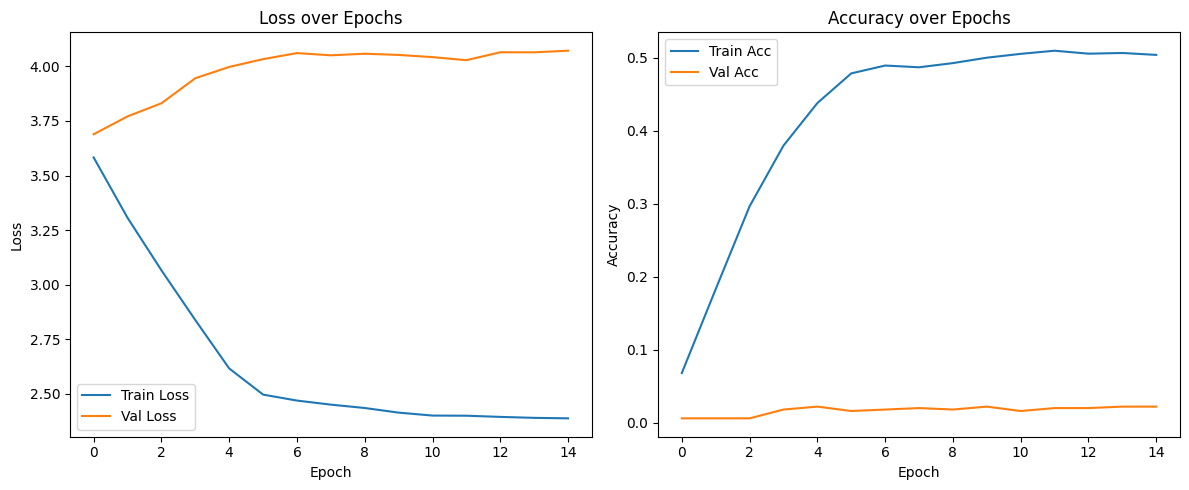

In [95]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### MobileNetV3 Conclusion:

I would say the model performed worse than I expected compared to SimpleCNN. The validation and test accuracy reflects the fact that the data is too noisy and irrelevant to each other within the classes.

For the future I would say it will be better to use a YOLO based labeled dataset, for these kind of purpose.